### Part 3.3 BiGru Model
BiGRU model stands for Bidirectional Gated Recurrent Unit, which is a type of recurrent neural network (RNN). Similarly to LSTM, GRU is designed to model sequential data by allowing information to be selectively remembered or forgotten over time. However, in GRU, the memory cell state is replaced with a "candidate activation vector", which is updated using two gates: the reset gate and update gate. 

GRU consists of two gates: 
- Update gate selects whether the hidden state is to be updated with a new hidden state
- Reset gate decides whether the previous hidden state is ignored. 

The weight matrix will be created by BatchIterator class  based on the Glove word vectors we want to use and vocabularly word2index dictionary. For each word, index pair from word2index, the weight matrix at the position equals index will be set with the Glove vector that represents given word. 

For words that haven't been found in the Glove mapping, the random vector will be initialised. Then the weight matrix will be passed to the embedding layer as its parameters. 

It is very important to set the embedding_layer.weight.requires_grad = False, so that weights will not be updated during the training. After the GRU layer, extra features will be concatenated toehter with max-pooled, avg-pooled and last hidden size. The concatenated tensor will be next passed to the linear layer, so we have to set the input size to hidden_size * 3 + num_features.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from common_utils import UNK_TOKEN,EMBEDDING_DIM,SAVE_DIR,VOCAB_PATH,EMBEDDING_MATRIX_PATH,WORD2IDX_PATH,IDX2WORD_PATH,tokenize, EmbeddingMatrix, CustomDatasetPreparer, set_seed
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
set_seed(42)

In [2]:
# Load Dataset using CustomDatasetPreparer

BATCH_SIZE = 64
dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [3]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()
word_embeddings.unk_idx

16164

In [4]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_size):
        super(SelfAttentionLayer, self).__init__()
        self.feature_size = feature_size

        # Linear transformations for Q, K, V from the same source
        self.key = nn.Linear(feature_size, feature_size)
        self.query = nn.Linear(feature_size, feature_size)
        self.value = nn.Linear(feature_size, feature_size)

    def forward(self, x, mask=None):
        # Apply linear transformations
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))

        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Multiply weights with values
        output = torch.matmul(attention_weights, values)

        return output, attention_weights


In [5]:
class BiLSTMGRU(nn.Module):
    """
    BiDirectional LSTM/GRU neural network model with pre-trained word embeddings.

    Parameters
    -----------
    hidden_size: int 
        Number of features in the hidden state
    weight_matrix: numpy.ndarray 
        Matrix of pre-trained word embeddings (word_embedding)
    output_size: int
        Number of classes 
    n_layer: int, optional (default=1)
        Number of stacked recurrent layers. 
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout. 
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU. 
    GRU: boolean, optional (default=True)
        Whether to use GRU or LSTM. 
    """

    def __init__(self, hidden_size, weights_matrix: EmbeddingMatrix, output_size, n_layers=1, dropout=0.2, spatial_dropout=True, bidirectional=True, attention = False,  GRU = True):

        # Inherit everything from the nn.Module
        super(BiLSTMGRU, self).__init__()

        # Initialise attributes
        self.hidden_size = hidden_size
        self.weights_matrix = weights_matrix
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        self.use_attention = attention
        self.use_gru = GRU

        self.embedding_dim = self.weights_matrix.dimension

        # Embedding layer - Convert words into vectors of numbers that capture their meaning from pretrained word embeddings.
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(self.weights_matrix.embedding_matrix, dtype=torch.float), freeze=False)

        # Define dropout layers - Randomly set some neurons to zero during training to prevent overfitting
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout1d(self.dropout_p)

        # Define GRU / LSTM layer
        if self.use_gru:
            self.main = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True, bidirectional=self.bidirectional)
        else:
            self.main = nn.LSTM(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True, bidirectional=self.bidirectional)
        
        if self.use_attention:
            self.self_attention = SelfAttentionLayer(self.hidden_size * 2)

        # Linear layer input size is equal to hidden_size * (4 with attention / 3 without), becuase
        # we are concatenating max_pooling ,avg_pooling, (2 * self Attn / last_hidden) and additional features
        self.linear = nn.Linear(self.hidden_size * (4 if self.use_attention else 3), self.output_size)

    def forward(self, input_seq, input_feat, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_feat: torch.Tensor
            Batch of additional features.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract input_size (Batch size)
        self.input_size = input_seq.size(0)
        #check if word is unknown and not in vocab, replace with unk_idx
        GetIdxOrUnk = lambda x: x if self.weights_matrix.idx2word.get(str(x), None) else self.weights_matrix.unk_idx
        input_seq.apply_(lambda x: GetIdxOrUnk(x)) 

        # Embeddings shapes of input
        # Input: (input_size,  seq_length)
        # Output: (input_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)

        # Pass the emebedding layer to the dropout layer
        if self.spatial_dropout:
            # Convert to (input_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            # Dropout1d layer
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (input_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)

        else:
            emb_out = self.dropout(emb_out)

        # Pack padded batch of sequences for RNN module
        # Removes the padding and concatenates the sequences along the time dimension
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through the GRU Layer
        if self.use_gru:
            main_out, hidden = self.main(packed_emb, hidden)
        else:
            main_out, (hidden, cell_state) = self.main(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # hidden (h_n) comprises the hidden states after the entire sequence

        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, input_size, hidden_size)
        # Separate hidden state layers
        # Process the hidden layer
        hidden = hidden.view(self.n_layers, self.n_directions, self.input_size, self.hidden_size)
        last_hidden = hidden[-1]

        # Since Bidirectional: Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)

        # Pad a packed batch
        main_out, lengths = nn.utils.rnn.pad_packed_sequence(main_out, batch_first=True)

        if self.use_attention:
            # Self-attention layer
            attention_output, attention_weights = self.self_attention(main_out)
            # Mean Pooling of self-attention to reduce dimensions
            attention_output_mean = torch.mean(attention_output, dim=1)

        # print(last_hidden.shape)
        # print(attention_output.shape)
        # print(attention_output_mean.shape)
        # Combine the GRU outputs
        if self.bidirectional:
            main_out = main_out[:, :, :self.hidden_size] + main_out[:, :, self.hidden_size:]

        # Get Max and Average Pooling

        # Select the maximum value over each dimension of the hidden representation (max pooling)
        max_pool = F.adaptive_max_pool1d(main_out.permute(0, 2, 1), (1,)).view(self.input_size, -1)

        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (input_size, hidden_size)
        avg_pool = torch.sum(main_out, dim=1) / lengths.view(-1, 1).type(torch.FloatTensor)

        # Concatenate max_pooling, avg_pooling, hidden state and input_feat tensor (Combining all features)
        concat_out = torch.cat([attention_output_mean if self.use_attention else last_hidden, max_pool, avg_pool, input_feat], dim=1)

        # Pass through the linear layer and apply Softmax layer
        out = self.linear(concat_out)
        return out


In [6]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 40 
spatial_dropout = True

# Create BiGru model without attention
BiGruModel = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, early_stopping):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model.train()
    best_val_loss = np.inf
    patience = 3  # Number of epochs to wait before stopping
    trigger_times = 0

    for epoch in range(num_epochs):
        total_loss = 0
        correct_preds = 0
        total_samples = 0
        for batch in train_loader:
            sequences, features, lengths, labels = batch

            # Move tensors to device (GPU or CPU)
            sequences = sequences.to(device)
            features = features.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            set_seed(42) # https://datascience.stackexchange.com/a/56615 bug?
            # Forward pass
            outputs = model(sequences, features, lengths)
            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping (for example, clipping the gradients' norm at 3.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        scheduler.step()
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f'Early Stopping at {epoch+1}')
                    break

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct_pred = 0
    total_samples = 0

    with torch.no_grad():
        set_seed(42)
        for batch in data_loader:
            sequences, features, lengths, labels = batch

            # Move tensors to device
            sequences = sequences.to(device)
            features = features.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            outputs = model(sequences, features, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_pred += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_pred / total_samples
    # print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy


In [7]:
import matplotlib.pyplot as plt

def run_model(model, early_stopping):
    print(model)

    # Create loss function
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    model = model.to(device)

    EPOCHS = 10
    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler, early_stopping)
    evaluate(model, val_loader, criterion)
    evaluate(model, test_loader, criterion)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
        
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.show()

    return test_loss, test_accuracy 

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/40], Train Loss: 0.7079, Train Accuracy: 0.5273, Val Loss: 0.6695, Val Accuracy: 0.6023
Epoch [2/40], Train Loss: 0.5986, Train Accuracy: 0.7023, Val Loss: 0.5424, Val Accuracy: 0.7411
Epoch [3/40], Train Loss: 0.4039, Train Accuracy: 0.8171, Val Loss: 0.4696, Val Accuracy: 0.7767
Epoch [4/40], Train Loss: 0.2584, Train Accuracy: 0.9021, Val Loss: 0.4697, Val Accuracy: 0.7767
Epoch [5/40], Train Loss: 0.2404, Train Accuracy: 0.9093, Val Loss: 0.4722, Val Accuracy: 0.7777
Early Stopping at 6
Test Loss: 0.4315, Test Accuracy: 0.8011


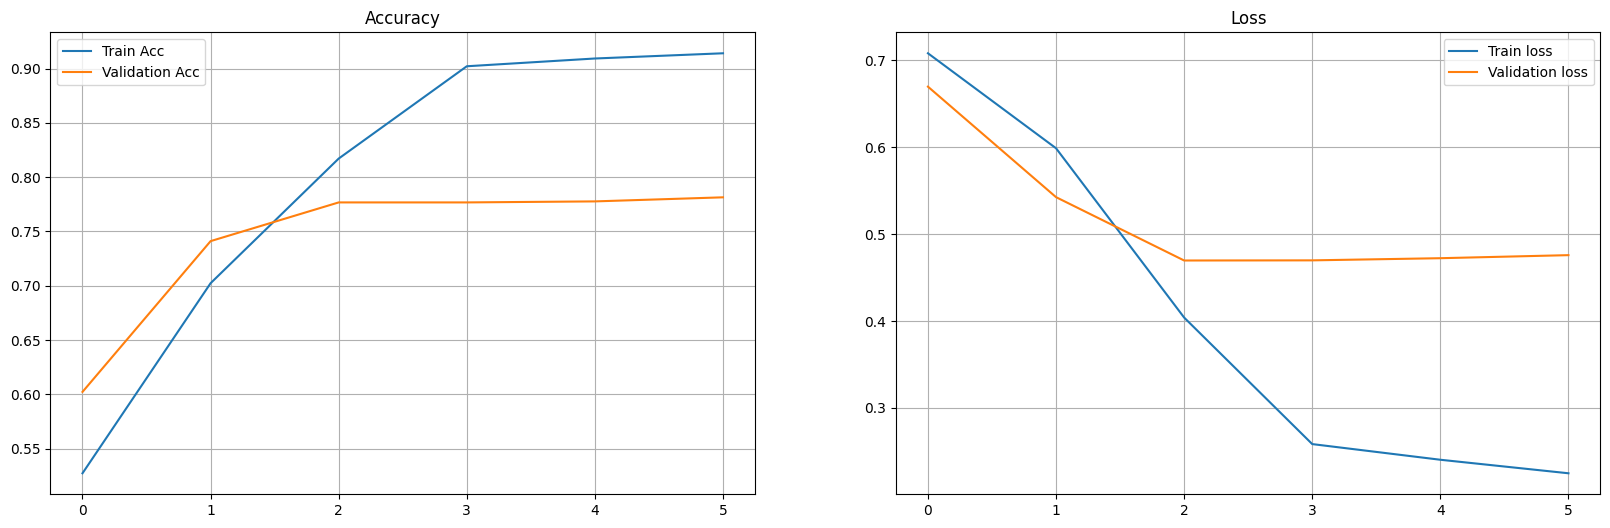

In [11]:
bigru_loss, bigru_accuracy = run_model(BiGruModel, True) # GRU no attention

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (self_attention): SelfAttentionLayer(
    (key): Linear(in_features=16, out_features=16, bias=True)
    (query): Linear(in_features=16, out_features=16, bias=True)
    (value): Linear(in_features=16, out_features=16, bias=True)
  )
  (linear): Linear(in_features=32, out_features=2, bias=True)
)
Epoch [1/40], Train Loss: 0.6897, Train Accuracy: 0.5427, Val Loss: 0.6732, Val Accuracy: 0.5966
Epoch [2/40], Train Loss: 0.6187, Train Accuracy: 0.6778, Val Loss: 0.5782, Val Accuracy: 0.7176
Epoch [3/40], Train Loss: 0.4347, Train Accuracy: 0.8061, Val Loss: 0.4911, Val Accuracy: 0.7645
Epoch [4/40], Train Loss: 0.2719, Train Accuracy: 0.8945, Val Loss: 0.4942, Val Accuracy: 0.7674
Epoch [5/40], Train Loss: 0.2513, Train Accuracy: 0.9033, Val Loss: 0.5010, Val Accuracy: 0.7692
Early Stopp

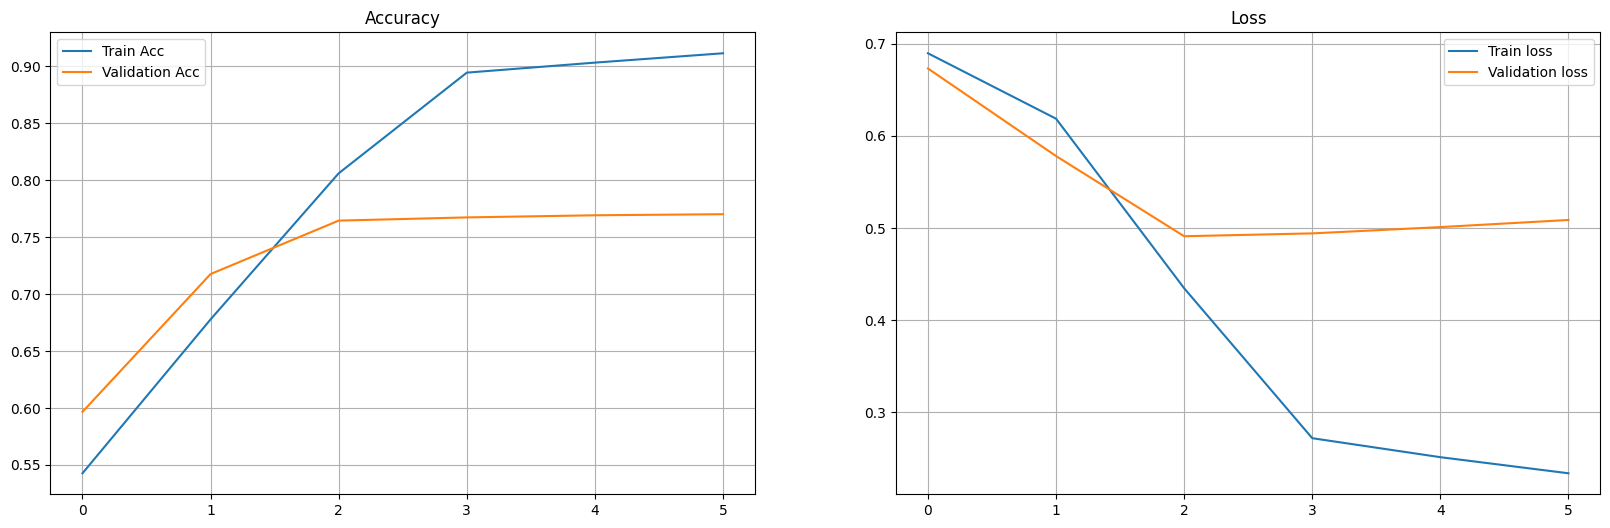

In [19]:
biGRU_w_attention = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=True, GRU=True)
biGRU_w_attention_loss, biGRU_w_attention_accuracy = run_model(biGRU_w_attention, True) # GRU attention

### Hyperparameter Fine-Tuning

After the model is created, we have to further tune its hyperparameters like the hidden_size, dropout, spatial_dropout, learning_rate and then determine the set of parameters that enable the model to achieve its best performance ( a model that returns the highest accuracy or lowest loss ) on the validation set. 

Below we will show how the training and validation losses change during the training, so we will have to disable early stopping. 

The initial parameters used in our model are as follows:
- hidden_size = 8
- output_size = 2
- n_layers = 1
- dropout = 0.5
- learning_rate = 0.001
- num_epochs = 40 
- spatial_dropout = True

### 1. Learning curves for the model with dropout set to 0.2 without spatial_dropout

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.6780, Train Accuracy: 0.5755, Val Loss: 0.6431, Val Accuracy: 0.6435
Epoch [2/10], Train Loss: 0.5556, Train Accuracy: 0.7305, Val Loss: 0.5213, Val Accuracy: 0.7270
Epoch [3/10], Train Loss: 0.3779, Train Accuracy: 0.8375, Val Loss: 0.4654, Val Accuracy: 0.7645
Epoch [4/10], Train Loss: 0.2533, Train Accuracy: 0.9082, Val Loss: 0.4686, Val Accuracy: 0.7664
Epoch [5/10], Train Loss: 0.2395, Train Accuracy: 0.9127, Val Loss: 0.4700, Val Accuracy: 0.7655
Epoch [6/10], Train Loss: 0.2267, Train Accuracy: 0.9170, Val Loss: 0.4722, Val Accuracy: 0.7720
Epoch [7/10], Train Loss: 0.2167, Train Accuracy: 0.9215, Val Loss: 0.4707, Val Accuracy: 0.7702
Epoch [8/10], Train Loss: 0.2153, Train Accuracy: 0.9226, Val Loss: 0.4704, Val Accuracy: 0.7702
Epoch [9/

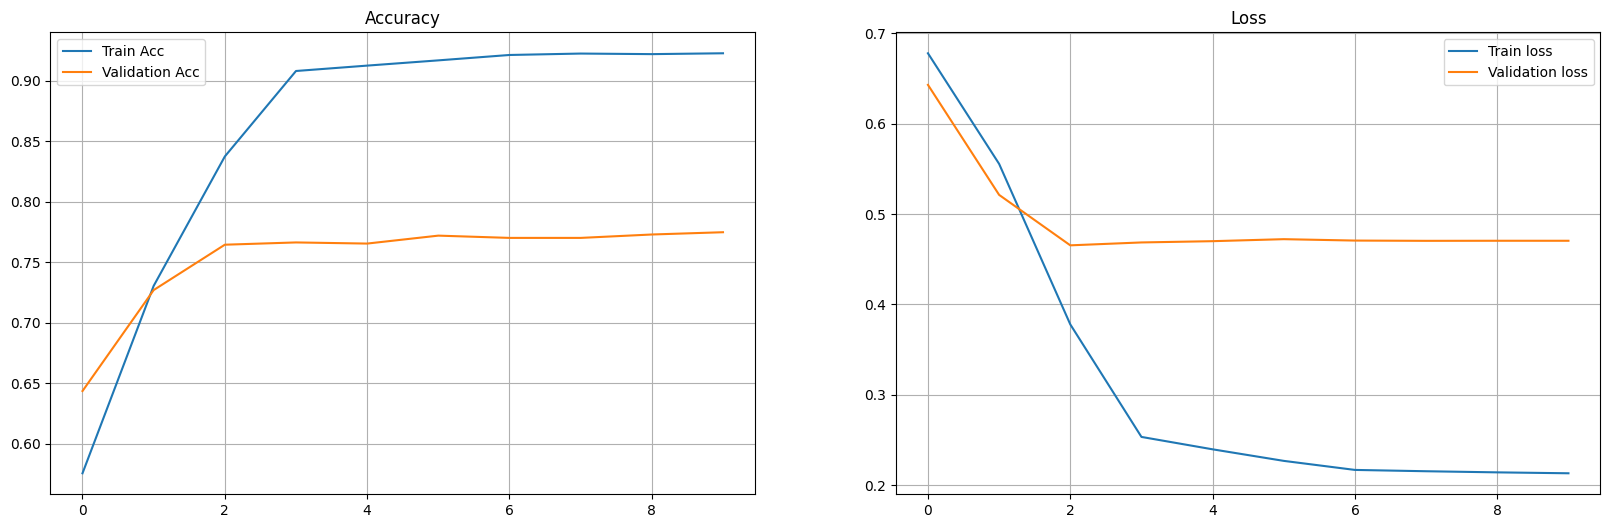

In [11]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.2
learning_rate = 0.001
num_epochs = 10
spatial_dropout = False

# Create BiGru model without attention
BiGruModel_dropout_2 = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel_dropout_2, False)

We can notice that the training loss constantly decrease together with the validation loss, however, there is a slight increase in the validation loss. This behaviour indiciates that our model is overfitted, it suggests that the model is learning too well how to map training input variables to the target, thus it cannot generalise its performance on some unseen data. 

So, one solution is to increase the dropout probability, so that overfitting will be reduced. 

### 2. Learning curves for the model with dropout set to 0.5 without spatial_dropout

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.6970, Train Accuracy: 0.5414, Val Loss: 0.6644, Val Accuracy: 0.6144
Epoch [2/10], Train Loss: 0.6059, Train Accuracy: 0.6887, Val Loss: 0.5648, Val Accuracy: 0.7054
Epoch [3/10], Train Loss: 0.4271, Train Accuracy: 0.8166, Val Loss: 0.4709, Val Accuracy: 0.7655
Epoch [4/10], Train Loss: 0.2851, Train Accuracy: 0.8918, Val Loss: 0.4721, Val Accuracy: 0.7711
Epoch [5/10], Train Loss: 0.2688, Train Accuracy: 0.8966, Val Loss: 0.4724, Val Accuracy: 0.7749
Epoch [6/10], Train Loss: 0.2540, Train Accuracy: 0.9025, Val Loss: 0.4739, Val Accuracy: 0.7730
Epoch [7/10], Train Loss: 0.2427, Train Accuracy: 0.9089, Val Loss: 0.4726, Val Accuracy: 0.7739
Epoch [8/10], Train Loss: 0.2411, Train Accuracy: 0.9093, Val Loss: 0.4724, Val Accuracy: 0.7739
Epoch [9/

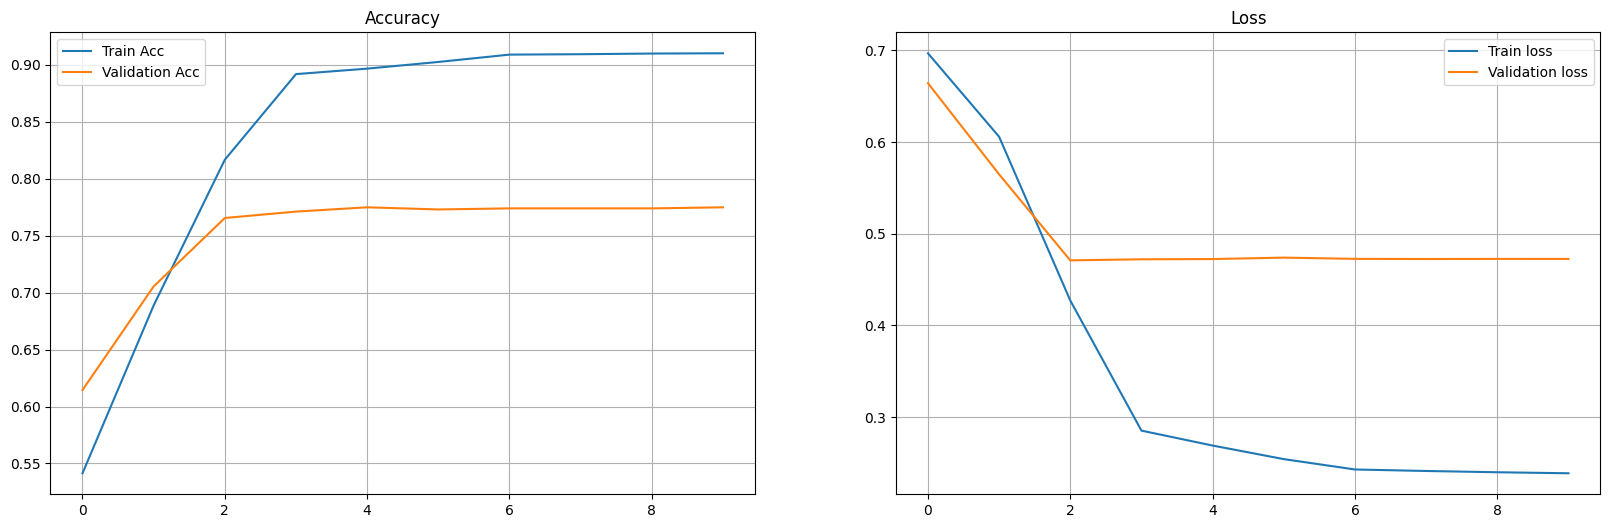

In [10]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 10
spatial_dropout = False

# Create BiGru model without attention
BiGruModel_dropout_5 = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel_dropout_5, False)

### 3. Learning curves for the model with dropout set to 0.5 with spatial_dropout

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.6974, Train Accuracy: 0.5417, Val Loss: 0.6668, Val Accuracy: 0.6116
Epoch [2/10], Train Loss: 0.6191, Train Accuracy: 0.6751, Val Loss: 0.5827, Val Accuracy: 0.7101
Epoch [3/10], Train Loss: 0.4532, Train Accuracy: 0.8028, Val Loss: 0.4761, Val Accuracy: 0.7608
Epoch [4/10], Train Loss: 0.3133, Train Accuracy: 0.8822, Val Loss: 0.4740, Val Accuracy: 0.7683
Epoch [5/10], Train Loss: 0.2961, Train Accuracy: 0.8873, Val Loss: 0.4715, Val Accuracy: 0.7739
Epoch [6/10], Train Loss: 0.2804, Train Accuracy: 0.8927, Val Loss: 0.4704, Val Accuracy: 0.7739
Epoch [7/10], Train Loss: 0.2687, Train Accuracy: 0.8970, Val Loss: 0.4689, Val Accuracy: 0.7692
Epoch [8/10], Train Loss: 0.2670, Train Accuracy: 0

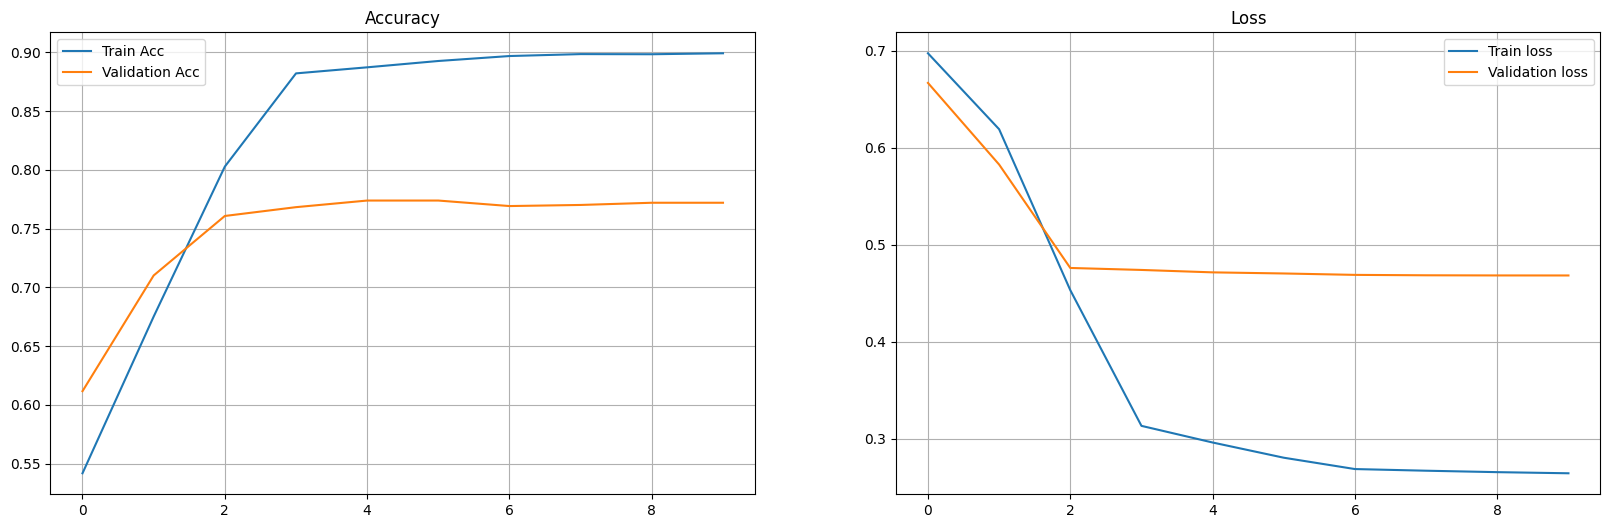

In [12]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 10
spatial_dropout = True

# Create BiGru model without attention
BiGruModel_dropout_5 = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel_dropout_5, False)

### 4. Learning curves for the model with hidden_size = 64

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=192, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.6425, Train Accuracy: 0.6238, Val Loss: 0.5954, Val Accuracy: 0.6989
Epoch [2/10], Train Loss: 0.4719, Train Accuracy: 0.7653, Val Loss: 0.4628, Val Accuracy: 0.7730
Epoch [3/10], Train Loss: 0.3170, Train Accuracy: 0.8627, Val Loss: 0.4796, Val Accuracy: 0.7795
Epoch [4/10], Train Loss: 0.1813, Train Accuracy: 0.9347, Val Loss: 0.5176, Val Accuracy: 0.7805
Epoch [5/10], Train Loss: 0.1630, Train Accuracy: 0.9413, Val Loss: 0.5416, Val Accuracy: 0.7767
Epoch [6/10], Train Loss: 0.1487, Train Accuracy: 0.9475, Val Loss: 0.5617, Val Accuracy: 0.7767
Epoch [7/10], Train Loss: 0.1355, Train Accuracy: 0.9517, Val Loss: 0.5667, Val Accuracy: 0.7749
Epoch [8/10], Train Loss: 0.1341, Train Accuracy:

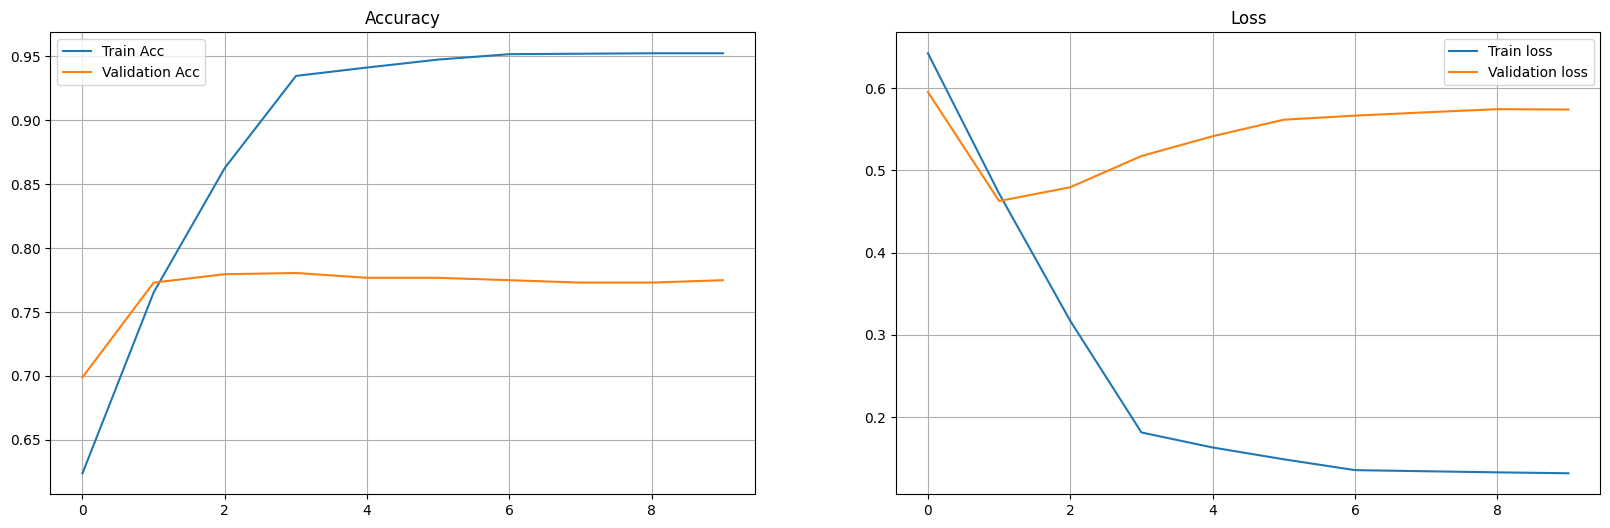

In [17]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 10
spatial_dropout = True

# Create BiGru model without attention
BiGruModel = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel, False)

As we can see, as we increase the number of hidden layers to 64, validation loss increases after the first epochs while the training loss continually decreases. 

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 32, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=96, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.6647, Train Accuracy: 0.5882, Val Loss: 0.6082, Val Accuracy: 0.6857
Epoch [2/10], Train Loss: 0.5016, Train Accuracy: 0.7543, Val Loss: 0.4619, Val Accuracy: 0.7711
Epoch [3/10], Train Loss: 0.3359, Train Accuracy: 0.8537, Val Loss: 0.4588, Val Accuracy: 0.7908
Epoch [4/10], Train Loss: 0.2023, Train Accuracy: 0.9281, Val Loss: 0.4721, Val Accuracy: 0.7871
Epoch [5/10], Train Loss: 0.1832, Train Accuracy: 0.9342, Val Loss: 0.4931, Val Accuracy: 0.7852
Epoch [6/10], Train Loss: 0.1683, Train Accuracy: 0.9375, Val Loss: 0.5105, Val Accuracy: 0.7899
Epoch [7/10], Train Loss: 0.1551, Train Accuracy: 0.9427, Val Loss: 0.5143, Val Accuracy: 0.7889
Epoch [8/10], Train Loss: 0.1538, Train Accuracy: 

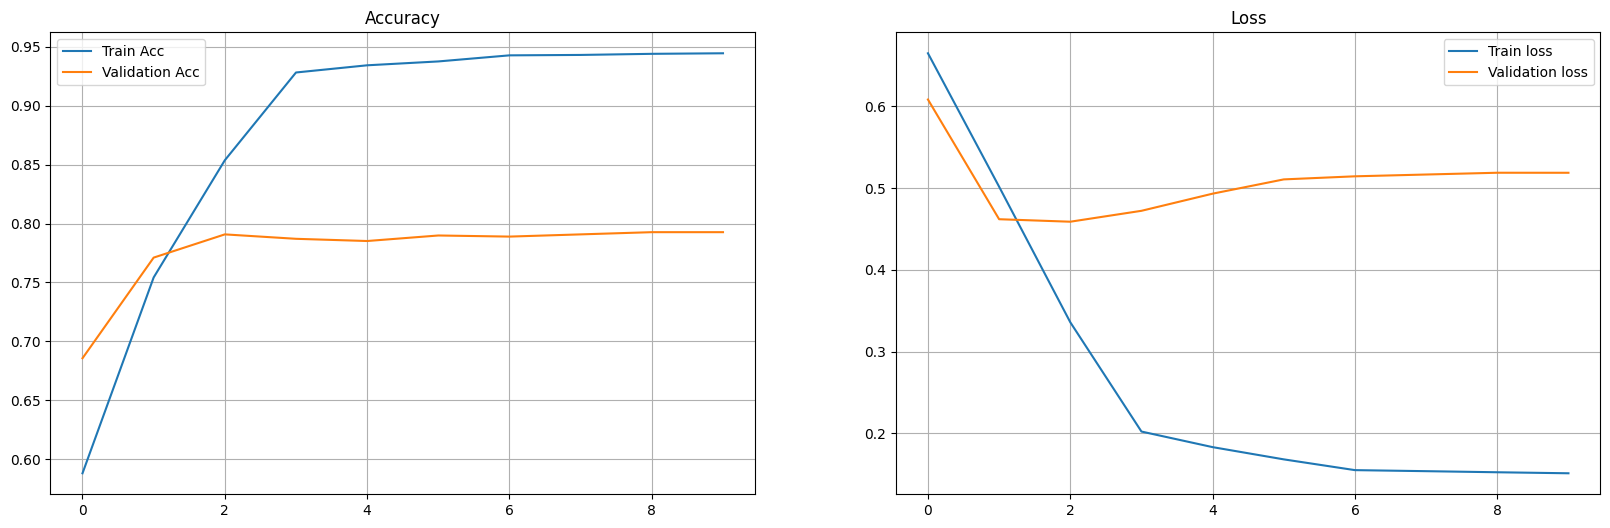

In [18]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 32
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 10
spatial_dropout = True

# Create BiGru model without attention
BiGruModel = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel, False)

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 16, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=48, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.6878, Train Accuracy: 0.5519, Val Loss: 0.6528, Val Accuracy: 0.6417
Epoch [2/10], Train Loss: 0.5677, Train Accuracy: 0.7159, Val Loss: 0.5068, Val Accuracy: 0.7533
Epoch [3/10], Train Loss: 0.3823, Train Accuracy: 0.8246, Val Loss: 0.4621, Val Accuracy: 0.7805
Epoch [4/10], Train Loss: 0.2438, Train Accuracy: 0.9077, Val Loss: 0.4704, Val Accuracy: 0.7814
Epoch [5/10], Train Loss: 0.2255, Train Accuracy: 0.9129, Val Loss: 0.4795, Val Accuracy: 0.7795
Epoch [6/10], Train Loss: 0.2101, Train Accuracy: 0.9182, Val Loss: 0.4890, Val Accuracy: 0.7795
Epoch [7/10], Train Loss: 0.1979, Train Accuracy: 0.9238, Val Loss: 0.4898, Val Accuracy: 0.7805
Epoch [8/10], Train Loss: 0.1965, Train Accuracy: 

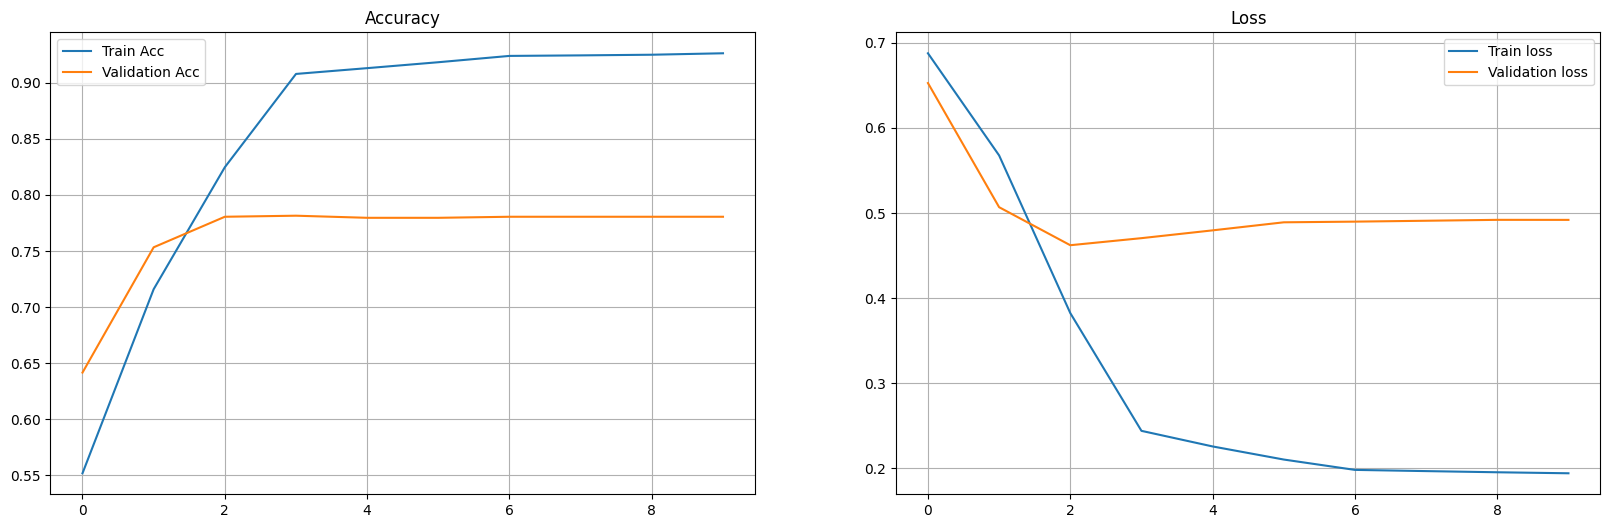

In [19]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 16
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 10
spatial_dropout = True

# Create BiGru model without attention
BiGruModel = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel, False)

BiLSTMGRU(
  (embedding): Embedding(16165, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (spatial_dropout1d): Dropout1d(p=0.5, inplace=False)
  (main): GRU(100, 8, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=24, out_features=2, bias=True)
)
Epoch [1/10], Train Loss: 0.7079, Train Accuracy: 0.5273, Val Loss: 0.6695, Val Accuracy: 0.6023
Epoch [2/10], Train Loss: 0.5986, Train Accuracy: 0.7023, Val Loss: 0.5424, Val Accuracy: 0.7411
Epoch [3/10], Train Loss: 0.4039, Train Accuracy: 0.8171, Val Loss: 0.4696, Val Accuracy: 0.7767
Epoch [4/10], Train Loss: 0.2584, Train Accuracy: 0.9021, Val Loss: 0.4697, Val Accuracy: 0.7767
Epoch [5/10], Train Loss: 0.2404, Train Accuracy: 0.9093, Val Loss: 0.4722, Val Accuracy: 0.7777
Epoch [6/10], Train Loss: 0.2248, Train Accuracy: 0.9141, Val Loss: 0.4757, Val Accuracy: 0.7814
Epoch [7/10], Train Loss: 0.2128, Train Accuracy: 0.9210, Val Loss: 0.4760, Val Accuracy: 0.7758
Epoch [8/10], Train Loss: 0.2112, Train Accuracy: 0

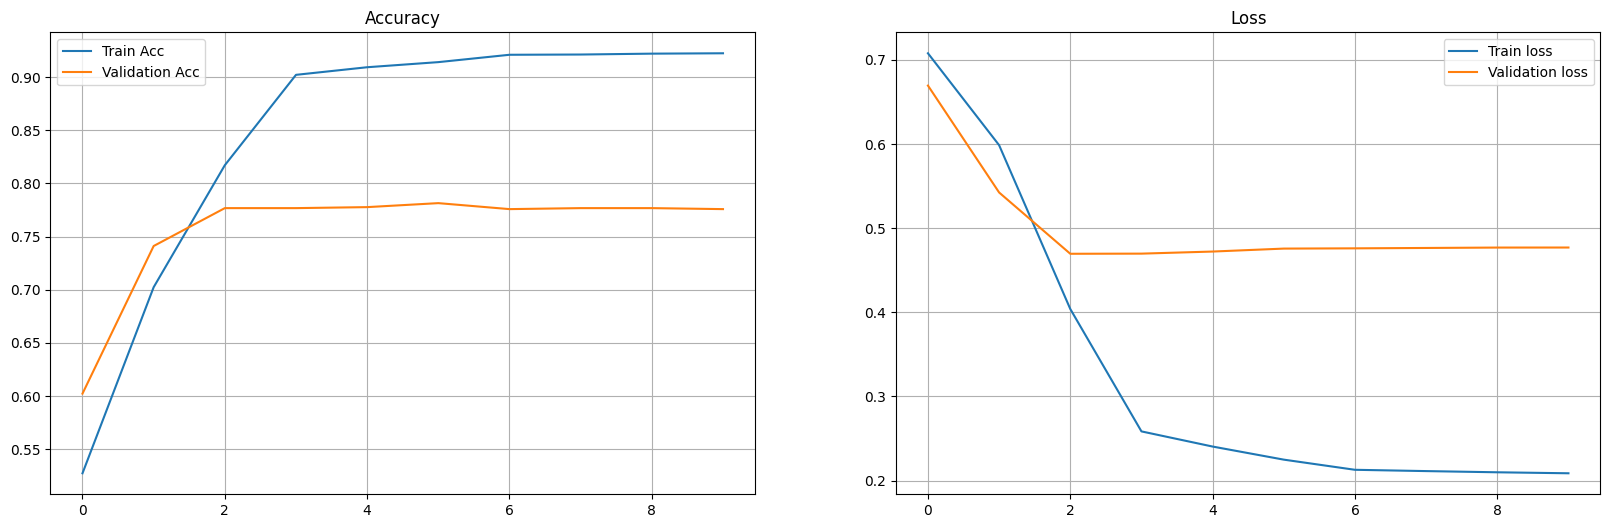

In [21]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 8
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 10
spatial_dropout = True

# Create BiGru model without attention
BiGruModel = BiLSTMGRU(hidden_size, word_embeddings, output_size, n_layers, dropout, spatial_dropout, bidirectional=True, attention=False, GRU=True)
loss, accuracy = run_model(BiGruModel, False)

#### Summary - Final sets of Hyperparameters
Considering all the above training trials, we can draw the following conclusions:
- Increasing dropout probability helps in reducing the model's overfitting
- Spatial dropout works better in terms of decreasing variance problem as compared to the traditional dropout
- Reducing the hidden_size will help in reducing overfitting

Final set of parameters are as follows:
- hidden_size = 8
- output_size = 2
- n_layers = 1
- dropout = 0.5
- learning_rate = 0.001
- num_epochs = 40 
- spatial_dropout = True